# COSC-x40: Lab 6

**Student Name**

[PLACEHOLDER_FOR_NOTEBOOK_LINK]


## Getting Started

Follow the instructions below to copy this notebook and to perform some initial setup.

1. Copy this notebook by selecting `File > Save a copy in Drive`.
2. A new window should open for the copied notebook. Move the new notebook to your course folder in Google Drive by selecting `File > Move` and then selecting the desired folder.
3. Update the name of the notebook by removing "Copy of" and replacing "Username" with your actual username.
4. Update the first cell in the notebook by specifying your course number (440 or 640) and by replacing "**Student Name**" with your actual name.
5. Do not edit the line that says `PLACEHOLDER_FOR_NOTEBOOK_LINK`. This will be used by the [Notebook Renderer](https://colab.research.google.com/drive/1CJTipys46ldZxJFwnt7XbdjQUfkmoXeU?usp=sharing) tool to insert a link to your Colab notebook.
6. Enable link sharing for your notebook.

## Preparing the Colab Environment

Run the cell below to download and extract the datasets required for this lab. All of the required datasets will then be stored on the Colab VM in a folder named `data/`.

In [1]:
%%capture
!wget -nc https://github.com/drbeane/datasets/raw/main/COSC_640_data.zip
!unzip -n COSC_640_data.zip -d data/

Run the cell below to import the necessary tools for this assignment. **No other import statements are required for this Lab, and no other import statements should be included in this assignment.**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose  import ColumnTransformer

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Part 1: Data Preparation (Census Data)

In Parts 1 and 2, you will be working with the "Census Income" dataset. In Part 1, you will prepare the data and in Part 2, you will select, train, and apply a model.

Your goal will be to create a model to predict whether or not an individual has an annual salary greater than $50,000 based on various demographic factors. You can find more information about the dataset, including a description of the features here: [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/adult).

Note that the label values are stored in the `income` column. All other columns represent features. All feature columns containing numerical values represent numerical features and all feature columns containing string values represent categorical features.

**Note:** In the interest of time, you will work with only half of the Census dataset in Parts 1 and 2. Some of the cross validations steps would require a significant amount of time to run in the Colab environment if we were to run them on the entire dataset.

## 1.A - Load the Data

Load the data from the file `data/census.csv` into a DataFrame. Use the `sample()` method to shuffle the data, setting `frac=0.5` and `random_state=1`. Display the head of the DataFrame.

**Pay careful attention to the instructions above regarding the parameters for `sample()`.**

In [3]:
census = pd.read_csv('data/census.csv')
census = census.sample(frac=0.5, random_state=1)
census.head()

,age,workclass,fnlwgt,education,educ_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hrs_per_week,native_country,income
9646,24,Private,336088,HS-grad,9,Divorced,Exec-managerial,Not-in-family,Amer-Indian-Eskimo,Female,0,0,50,United-States,<=50K
709,34,Federal-gov,190228,Bachelors,13,Married-civ-spouse,Protective-serv,Husband,White,Male,0,1902,48,United-States,>50K
7385,18,Private,104704,HS-grad,9,Never-married,Adm-clerical,Own-child,Black,Male,0,0,40,United-States,<=50K
16671,44,Private,36271,Bachelors,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
21932,27,Private,178709,Masters,14,Never-married,Machine-op-inspct,Not-in-family,White,Female,0,0,40,United-States,<=50K


## 1.B - Label Distribution

Create a label array and use `value_counts()` to display the distribution of the label values as proportions.

In [4]:
y = census.income.values
census.income.value_counts(normalize=True)

,proportion
income,
<=50K,0.75688
>50K,0.24312


## 1.C - Grouping Features

Create lists containing the names of the numerical and categorical features. Print these lists along with messages indicating which features are numerical and which are categorical.

In [5]:
num_features = census.columns.values[[0,2,4,10,11,12]]
cat_features = census.columns.values[[1,3,5,6,7,8,9,13]]

print('Numerical Features:')
print(num_features)
print()
print('Categorical Features:')
print(cat_features)

Numerical Features:
['age' 'fnlwgt' 'educ_num' 'capital_gain' 'capital_loss' 'hrs_per_week']

Categorical Features:
['workclass' 'education' 'marital_status' 'occupation' 'relationship'
 'race' 'sex' 'native_country']


## 1.D - Counting Levels

Determine the number of levels for each categorical feature. Display the results my printing a message of the following form for each feature:

    [feature] has [num_levels] levels.

The bracketed expressions should be replaced with the appropriate values.

In [6]:
for c in cat_features:
    print(f'{c} has {len(census[c].unique())} levels.')

workclass has 9 levels.
education has 16 levels.
marital_status has 7 levels.
occupation has 15 levels.
relationship has 6 levels.
race has 5 levels.
sex has 2 levels.
native_country has 42 levels.


## 1.E - Data Preprocessing

Create instances of `StandardScaler` and `OneHotEncoder` and then use them to create an instance of `ColumnTransformer`, applying each preprocessing object to the appropriate columns. Then fit and apply your `ColumnTransformer` to the DataFrame containing your training data. Store the resulting feature array in a variable.

Print the shape of the final feature array.

**Use the preprocessed features when training, evaluating, or applying models in Part 2.**

In [7]:
scaler = StandardScaler()
encoder = OneHotEncoder()

preprocessor = ColumnTransformer([
    ('scaler', scaler, num_features),
    ('encoder', encoder, cat_features)
])

X = preprocessor.fit_transform(census)
X.shape

(16280, 108)

# Part 2: Selecting and Applying a Model (Census Data)

We will now perform hyperparameter tuning and model selection. After identifying the preferred model, we will analyze its preformance.

## 2.A - Cross Validation for Logistic Regression

Create an instance of `LogisticRegression`. Use `cross_value_score()` to estimate the model's out-of-sample
performance on the dataset. Use 5-fold CV with accuracy as the metric and set `n_jobs=-1`. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

In [8]:
lr_mod = LogisticRegression()

scores = cross_val_score(lr_mod, X, y, cv=10, scoring='accuracy', n_jobs=-1)
print('Scores:', scores.round(3))
print('CV Score:', scores.mean().round(3))

Scores: [0.864 0.852 0.859 0.857 0.861 0.857 0.856 0.848 0.851 0.864]
CV Score: 0.857


## 2.B - Hyperparameter Tuning for KNN

Create an instance of `KNeighborsClassifier` specifying no parameter values.  Use `GridSearchCV` to perform hyperparameter tuning with 5-fold cross validation for your KNN model. Score your models according to accuracy and set `n_jobs=-1`. Tune over the `n_neighbors` parameter, considering the following hyperparameter values: **16, 18, 20, 22, 24**

Print the best hyperparameter value found by grid search, as well as the best score found. Add text to indicate the meaning of these values in the output.

In [9]:
knn_mod = KNeighborsClassifier()

knn_params = {
    'n_neighbors' : range(16, 26, 2)
}

knn_grid = GridSearchCV(knn_mod, knn_params, cv=10, n_jobs=-1)
knn_grid.fit(X, y)

print('Best Parameters:', knn_grid.best_params_)
print('Best CV Score:  ', knn_grid.best_score_)

Best Parameters: {'n_neighbors': 18}
Best CV Score:   0.8458845208845208


## 2.C - Visualizing Results

Replace the blank in line 1 of this cell with the name of your parameter dictionary from 2.B. Replace the blank in line 2 with the name of your `GridSearchCV` object from 2.B. Then execute this cell to see how the CV scores varied with respect to the hyperparameter values. Use this graph to determine if you should re-run the previous cell with a different range of hyperparameter values.

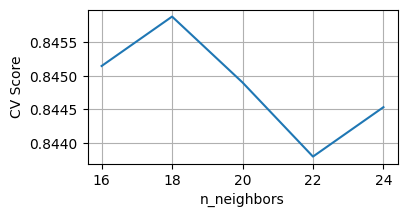

In [10]:
n_neighbors = knn_params['n_neighbors']
scores = knn_grid.cv_results_['mean_test_score']

plt.figure(figsize=[4,2])
plt.plot(n_neighbors, scores)
plt.xlabel('n_neighbors')
plt.ylabel('CV Score')
plt.grid()
plt.show()

## 2.D - Hyperparameter Tuning for Decision Trees

Create an instance of `DecisionTreeClassifer` with `random_state=1` but specifying no other parameter values.  Use `GridSearchCV` to perform hyperparameter tuning with 5-fold cross validation for your decision tree model. Score your models according to accuracy and set `n_jobs=-1`. Tune over the `max_depth` parameter, considering the following hyperparameter values: **4, 8, 12, 16, 20, 24**.

Print the best hyperparameter value found by grid search, as well as the best score found. Print additional text to indicate the meaning of these values in the output.

In [11]:
tree_mod = DecisionTreeClassifier(random_state=1)

tree_params = {
    'max_depth' : range(4, 28, 4)
}

tree_grid = GridSearchCV(tree_mod, tree_params, cv=10, n_jobs=-1)
tree_grid.fit(X, y)

print('Best Parameters:', tree_grid.best_params_)
print('Best CV Score:  ', tree_grid.best_score_)

Best Parameters: {'max_depth': 8}
Best CV Score:   0.8579852579852579


## 2.E - Visualizing Results

Replace the blank in line 1 of this cell with the name of your parameter dictionary from 2.D. Replace the blank in line 2 with the name of your `GridSearchCV` object from 2.D. Then execute this cell to see how the CV scores varied with respect to the hyperparameter values. Use this graph to determine if you should re-run the previous cell with a different range of hyperparameter values.

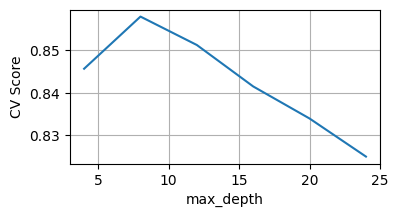

In [12]:
# 2.E
max_depth = tree_params['max_depth']
scores = tree_grid.cv_results_['mean_test_score']

plt.figure(figsize=[4,2])
plt.plot(max_depth, scores)
plt.xlabel('max_depth')
plt.ylabel('CV Score')
plt.grid()
plt.show()

## 2.F - Hyperparameter Tuning for Random Forests

Create an instance of `RandomForestClassifer` with `random_state=1` and `n_estimators=100` but specifying no other parameter values.  Use `GridSearchCV` to perform hyperparameter tuning with 5-fold cross validation for your random forest model. Score your models according to accuracy and set `n_jobs=-1`. Tune over the `max_depth` parameter, considering the following hyperparameter values: **12, 16, 20, 24, 28**.

Print the best hyperparameter value found by grid search, as well as the best score found. Print additional text to indicate the meaning of these values in the output.


In [13]:
rf_mod = RandomForestClassifier(random_state=1, n_estimators=100)

rf_params = {
    'max_depth' : range(12, 24, 4)
}

rf_grid = GridSearchCV(rf_mod, rf_params, cv=5, n_jobs=-1)
rf_grid.fit(X, y)

print('Best Parameters:', rf_grid.best_params_)
print('Best CV Score:  ', rf_grid.best_score_)

Best Parameters: {'max_depth': 20}
Best CV Score:   0.8648034398034398


## 2.G - Visualizing Results

Replace the blank in line 1 of this cell with the name of your parameter dictionary from 2.F. Replace the blank in line 2 with the name of your `GridSearchCV` object from 2.F. Then execute this cell to see how the CV scores varied with respect to the hyperparameter values.

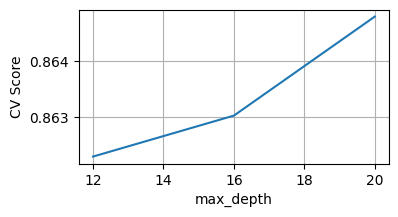

In [14]:
max_depth = rf_params['max_depth']
scores = rf_grid.cv_results_['mean_test_score']

plt.figure(figsize=[4,2])
plt.plot(max_depth, scores)
plt.xlabel('max_depth')
plt.ylabel('CV Score')
plt.grid()
plt.show()

## 2.H - Classification Report

Identify which of the models from above gave you the best results. Then use that model with `cross_val_predict()` with `cv=5` to generate out-of-sample predictions for the dataset. Use these predictions with `classification_report()` to generate a classification report.

In [15]:
final_model = rf_grid.best_estimator_

cv_pred1 = cross_val_predict(final_model, X, y, cv=5, n_jobs=-1)

print(classification_report(y, cv_pred1))

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91     12322
        >50K       0.79      0.61      0.69      3958

    accuracy                           0.86     16280
   macro avg       0.83      0.78      0.80     16280
weighted avg       0.86      0.86      0.86     16280



## 2.I - Confusion Matrix

Use your out-of-sample predictions with `confusion_matrix()` to generate a confusion matrix. Display the confusion matrix as a DataFrame, with the rows and columns labeled according to the actual class names.

In [16]:
cm1 = confusion_matrix(y, cv_pred1)
pd.DataFrame(cm1)

,0,1
0,11664,658
1,1543,2415


# Part 3: Data Preparation (Forest Cover Data)


In Parts 3 and 4, you will be working with the "Forest Cover" dataset. In Part 3, you will prepare the data and in Part 4, you will select, train, and apply a model.

Your goal will be to create a model to predict the forest cover type for patches of land in Colorado wilderness areas based on various cartographic information. You can find more information about the dataset, including a description of the features here: [Forest Cover Type Prediction](https://www.kaggle.com/c/forest-cover-type-prediction).

Note that the label values are stored in the `Cover_Type` column and have been integer encoded. All other columns represent features. The `Wilderness_Area` and `Soil_Type` columns represent categorical features. The  `Soil_Type` has been integer encoded, but should still be considered to be categorical. All other columns represent numerical features.


## 3.A - Load the Data

Load the data from the file `data/forest_cover.csv` into a DataFrame. Use the `sample()` method to shuffle the data, setting `random_state=1`. Display the head of the DataFrame.

In [17]:
forestcover = pd.read_csv('data/forest_cover.csv')
forestcover = forestcover.sample(frac=1, random_state=1)
forestcover.head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type,Cover_Type
5765,2489,333,18,124,39,458,176,214,176,1409,Cache la Poudre,10,6
11340,2696,4,13,30,10,2800,202,214,148,6524,Rawah,29,1
9270,3413,140,17,134,6,4271,243,233,113,4272,Comanche Peak,23,7
5710,2874,116,18,153,17,2379,248,220,94,564,Comanche Peak,13,5
1070,3001,57,18,180,28,4673,229,200,97,1864,Rawah,29,1


## 3.B - Label Distribution

Create a label array and use `value_counts()` to display the distribution of the label values as proportions.

In [18]:
y1 = forestcover.Cover_Type.values
forestcover.Cover_Type.value_counts(normalize=True)

,proportion
Cover_Type,
6,0.142857
1,0.142857
7,0.142857
5,0.142857
2,0.142857
4,0.142857
3,0.142857


## 3.C - Grouping Features

Create lists containing the names of the numerical and categorical features. Print these lists along with messages indicating which features are numerical and which are categorical.

In [19]:
num_features = forestcover.columns.values[[0,1,2,3,4,5,6,7,8,9,11]]
cat_features = forestcover.columns.values[[10]]

print('Numerical Features:')
print(num_features)
print()
print('Categorical Features:')
print(cat_features)

Numerical Features:
['Elevation' 'Aspect' 'Slope' 'Horizontal_Distance_To_Hydrology'
 'Vertical_Distance_To_Hydrology' 'Horizontal_Distance_To_Roadways'
 'Hillshade_9am' 'Hillshade_Noon' 'Hillshade_3pm'
 'Horizontal_Distance_To_Fire_Points' 'Soil_Type']

Categorical Features:
['Wilderness_Area']


## 3.D - Counting Levels

Determine the number of levels for each categorical feature. Display the results my printing a message of the following form for each feature:

    [feature] has [num_levels] levels.

The bracketed expressions should be replaced with the appropriate values.

In [20]:
for c in cat_features:
    print(f'{c} has {len(forestcover[c].unique())} levels.')

Wilderness_Area has 4 levels.


## 3.E - Data Preprocessing

Create instances of `StandardScaler` and `OneHotEncoder`, and then use them to create an instance of `ColumnTransformer`, applying each preprocessing object to the appropriate columns. Then fit and apply your `ColumnTransformer` to the DataFrame containing your training data. Store the resulting feature array in a variable.

Print the shape of the final feature array.

**Use the preprocessed features when training, evaluating, or applying models in Part 4.**

In [21]:
scaler = StandardScaler()
encoder = OneHotEncoder()

preprocessor1 = ColumnTransformer([
    ('scaler', scaler, num_features),
    ('encoder', encoder, cat_features)
])

X1 = preprocessor1.fit_transform(forestcover)
X1.shape

(15120, 15)

# Part 4: Selecting and Applying a Model (Forest Cover Data)

## 4.A - Cross Validation for Logistic Regression

Create an instance of `LogisticRegression`. Use `cross_value_score()` to estimate the model's out-of-sample
performance on the dataset. Use 5-fold CV with accuracy as the metric and set `n_jobs=-1`. Print the scores for each fold, as well as mean score. Round all scores to 3 decimal places.

In [22]:
lr_mod1 = LogisticRegression()

scores = cross_val_score(lr_mod, X1, y1, cv=5, scoring='accuracy', n_jobs=-1)
print('Scores:', scores.round(3))
print('CV Score:', scores.mean().round(3))

Scores: [0.687 0.68  0.683 0.687 0.676]
CV Score: 0.683


## 4.B - Hyperparameter Tuning for KNN

Create an instance of `KNeighborsClassifier` specifying no parameter values.  Use `GridSearchCV` to perform hyperparameter tuning with 5-fold cross validation for your KNN model. Score your models according to accuracy and set `n_jobs=-1`. Tune over the `n_neighbors` parameter, considering the following hyperparameter values: **1, 2, 3, 4, 5**

Print the best hyperparameter value found by grid search, as well as the best score found. Print additional text to indicate the meaning of these values in the output.

In [23]:
knn_mod1 = KNeighborsClassifier()

knn_params1 = {
    'n_neighbors' : range(1, 6, 1)
}

knn_grid1 = GridSearchCV(knn_mod1, knn_params1, cv=5, n_jobs=-1)
knn_grid1.fit(X1, y1)

print('Best Parameters:', knn_grid1.best_params_)
print('Best CV Score:  ', knn_grid1.best_score_)

Best Parameters: {'n_neighbors': 1}
Best CV Score:   0.798478835978836


## 4.C - Visualizing Results

Replace the blank in line 1 of this cell with the name of your parameter dictionary from 4.B. Replace the blank in line 2 with the name of your `GridSearchCV` object from 4.B. Then execute this cell to see how the CV scores varied with respect to the hyperparameter values. Use this graph to determine if you should re-run the previous cell with a different range of hyperparameter values.

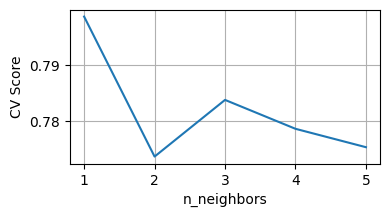

In [24]:
# 4.C
n_neighbors = knn_params1['n_neighbors']
scores = knn_grid1.cv_results_['mean_test_score']

plt.figure(figsize=[4,2])
plt.plot(n_neighbors, scores)
plt.xlabel('n_neighbors')
plt.ylabel('CV Score')
plt.grid()
plt.show()

## 4.D - Hyperparameter Tuning for Decision Trees

Create an instance of `DecisionTreeClassifer` with `random_state=1` but specifying no other parameter values.  Use `GridSearchCV` to perform hyperparameter tuning with 5-fold cross validation for your decision tree model. Score your models according to accuracy and set `n_jobs=-1`. Tune over the `max_depth` parameter, considering the following hyperparameter values: **4, 8, 12, 16, 20, 24**.

Print the best hyperparameter value found by grid search, as well as the best score found. Print additional text to indicate the meaning of these values in the output.

In [25]:
tree_mod1 = DecisionTreeClassifier(random_state=1)

tree_params1 = {
    'max_depth' : range(4, 28, 4)
}

tree_grid1 = GridSearchCV(tree_mod1, tree_params1, cv=5, n_jobs=-1)
tree_grid1.fit(X1, y1)

print('Best Parameters:', tree_grid1.best_params_)
print('Best CV Score:  ', tree_grid1.best_score_)

Best Parameters: {'max_depth': 20}
Best CV Score:   0.7857804232804233


## 4.E - Visualizing Results

Replace the blank in line 1 of this cell with the name of your parameter dictionary from 4.D. Replace the blank in line 2 with the name of your `GridSearchCV` object from 4.D. Then execute this cell to see how the CV scores varied with respect to the hyperparameter values. Use this graph to determine if you should re-run the previous cell with a different range of hyperparameter values.

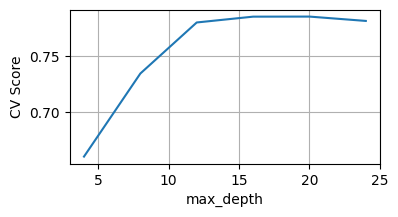

In [26]:
# 4.E
max_depth = tree_params1['max_depth']
scores = tree_grid1.cv_results_['mean_test_score']

plt.figure(figsize=[4,2])
plt.plot(max_depth, scores)
plt.xlabel('max_depth')
plt.ylabel('CV Score')
plt.grid()
plt.show()

## 4.F - Hyperparameter Tuning for Random Forests

Create an instance of `RandomForestClassifer` with `random_state=1` and `n_estimators=100` but specifying no other parameter values.  Use `GridSearchCV` to perform hyperparameter tuning with 5-fold cross validation for your random forest model. Score your models according to accuracy and set `n_jobs=-1`. Tune over the `max_depth` parameter, considering the following hyperparameter values: **24, 30, 36, 42, 48**.

Print the best hyperparameter value found by grid search, as well as the best score found. Print additional text to indicate the meaning of these values in the output.


In [27]:
rf_mod1 = RandomForestClassifier(random_state=1, n_estimators=100)

rf_params1 = {
    'max_depth' : range(24, 48, 6)
}

rf_grid1 = GridSearchCV(rf_mod1, rf_params1, cv=5, n_jobs=-1)
rf_grid1.fit(X1, y1)

print('Best Parameters:', rf_grid1.best_params_)
print('Best CV Score:  ', rf_grid1.best_score_)

Best Parameters: {'max_depth': 24}
Best CV Score:   0.8596560846560848


## 4.G - Visualizing Results

Replace the blank in line 1 of this cell with the name of your parameter dictionary from 4.F. Replace the blank in line 2 with the name of your `GridSearchCV` object from 4.F. Then execute this cell to see how the CV scores varied with respect to the hyperparameter values.

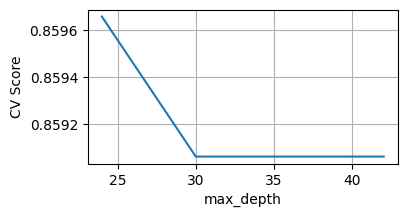

In [28]:
# 4.G
max_depth = rf_params1['max_depth']
scores = rf_grid1.cv_results_['mean_test_score']

plt.figure(figsize=[4,2])
plt.plot(max_depth, scores)
plt.xlabel('max_depth')
plt.ylabel('CV Score')
plt.grid()
plt.show()

## 4.H - Classification Report

Identify which of the models from above gave you the best results. Then use that model with `cross_val_predict()` with `cv=5` to generate out-of-sample predictions for the dataset. Use these predictions with `classification_report()` to generate a classification report.

In [30]:
final_model1 = rf_grid1.best_estimator_

cv_pred2 = cross_val_predict(final_model1, X1, y1, cv=5, n_jobs=-1)

print(classification_report(y1, cv_pred2))

              precision    recall  f1-score   support

           1       0.78      0.77      0.78      2160
           2       0.79      0.69      0.73      2160
           3       0.85      0.82      0.83      2160
           4       0.92      0.97      0.95      2160
           5       0.89      0.95      0.92      2160
           6       0.83      0.86      0.85      2160
           7       0.94      0.96      0.95      2160

    accuracy                           0.86     15120
   macro avg       0.86      0.86      0.86     15120
weighted avg       0.86      0.86      0.86     15120



## 4.I - Confusion Matrix

Use your out-of-sample predictions with `confusion_matrix()` to generate a confusion matrix. Display the confusion matrix as a DataFrame, with the rows and columns labeled according to the actual class names.

In [31]:
cm2 = confusion_matrix(y1, cv_pred2)
pd.DataFrame(cm2)

,0,1,2,3,4,5,6
0,1660,321,2,0,45,6,126
1,383,1488,50,0,172,53,14
2,0,7,1766,105,22,260,0
3,0,0,36,2097,0,27,0
4,2,58,33,0,2043,24,0
5,1,10,194,72,16,1867,0
6,76,5,0,0,2,0,2077


# Submission Instructions

1. Perform a Restart and Run All by clicking **Runtime > Restart session and run all**.
2. Copy the link to your notebook by clicking **Share > Copy Link**.
3. Paste the copied link into the `notebook_url` field in the [Notebook Renderer](https://colab.research.google.com/drive/1CJTipys46ldZxJFwnt7XbdjQUfkmoXeU?usp=sharing) tool and then execute the cell to render the notebook.
4. The Notebook Renderer will open up a save file dialog. Save the resulting HTML file yo your local machine.
5. Submit the HTML file to Canvas.
